# Linear Regression

Turing is powerful when applied to complex hierarchical models, but it can also be put to task at common statistical procedures, like [linear regression](https://en.wikipedia.org/wiki/Linear_regression). This tutorial covers how to implement a linear regression model in Turing.

## Set Up

We begin by importing all the necessary libraries.

In [1]:
# Import Turing and Distributions.
using Turing, Distributions

# Import RDatasets.
using RDatasets

# Import MCMCChains, Plots, and StatPlots for visualizations and diagnostics.
using MCMCChains, Plots, StatsPlots

# Functionality for splitting and normalizing the data.
using MLDataUtils: shuffleobs, splitobs, rescale!

# Functionality for evaluating the model predictions.
using Distances

# Set a seed for reproducibility.
using Random
Random.seed!(0)

# Hide the progress prompt while sampling.
Turing.setprogress!(false);

┌ Info: [Turing]: progress logging is disabled globally
└ @ Turing /Users/dtolpin/.julia/packages/Turing/PyTy2/src/Turing.jl:30
┌ Info: [AdvancedVI]: global PROGRESS is set as false
└ @ AdvancedVI /Users/dtolpin/.julia/packages/AdvancedVI/8ttTK/src/AdvancedVI.jl:15


We will use the `mtcars` dataset from the [RDatasets](https://github.com/johnmyleswhite/RDatasets.jl) package. `mtcars` contains a variety of statistics on different car models, including their miles per gallon, number of cylinders, and horsepower, among others.

We want to know if we can construct a Bayesian linear regression model to predict the miles per gallon of a car, given the other statistics it has. Lets take a look at the data we have.

In [2]:
# Import the "Default" dataset.
data = RDatasets.dataset("datasets", "mtcars");

# Show the first six rows of the dataset.
first(data, 6)

,Model,MPG,Cyl,Disp,HP,DRat,WT,QSec,VS
,String,Float64,Int64,Float64,Int64,Float64,Float64,Float64,Int64
1,Mazda RX4,21.0,6,160.0,110,3.9,2.62,16.46,0
2,Mazda RX4 Wag,21.0,6,160.0,110,3.9,2.875,17.02,0
3,Datsun 710,22.8,4,108.0,93,3.85,2.32,18.61,1
4,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1
5,Hornet Sportabout,18.7,8,360.0,175,3.15,3.44,17.02,0
6,Valiant,18.1,6,225.0,105,2.76,3.46,20.22,1


In [3]:
size(data)

(32, 12)

The next step is to get our data ready for testing. We'll split the `mtcars` dataset into two subsets, one for training our model and one for evaluating our model. Then, we separate the targets we want to learn (`MPG`, in this case) and standardize the datasets by subtracting each column's means and dividing by the standard deviation of that column. The resulting data is not very familiar looking, but this standardization process helps the sampler converge far easier.

In [4]:
# Remove the model column.
select!(data, Not(:Model))

# Split our dataset 70%/30% into training/test sets.
trainset, testset = splitobs(shuffleobs(data), 0.7)

# Turing requires data in matrix form.
target = :MPG
train = Matrix(select(trainset, Not(target)))
test = Matrix(select(testset, Not(target)))
train_target = trainset[:, target]
test_target = testset[:, target]

# Standardize the features.
μ, σ = rescale!(train; obsdim = 1)
rescale!(test, μ, σ; obsdim = 1)

# Standardize the targets.
μtarget, σtarget = rescale!(train_target; obsdim = 1)
rescale!(test_target, μtarget, σtarget; obsdim = 1);

## Model Specification

In a traditional frequentist model using [OLS](https://en.wikipedia.org/wiki/Ordinary_least_squares), our model might look like:

$$
MPG_i = \alpha + \boldsymbol{\beta}^\mathsf{T}\boldsymbol{X_i}
$$

where $\boldsymbol{\beta}$ is a vector of coefficients and $\boldsymbol{X}$ is a vector of inputs for observation $i$. The Bayesian model we are more concerned with is the following:

$$
MPG_i \sim \mathcal{N}(\alpha + \boldsymbol{\beta}^\mathsf{T}\boldsymbol{X_i}, \sigma^2)
$$

where $\alpha$ is an intercept term common to all observations, $\boldsymbol{\beta}$ is a coefficient vector, $\boldsymbol{X_i}$ is the observed data for car $i$, and $\sigma^2$ is a common variance term.

For $\sigma^2$, we assign a prior of `truncated(Normal(0, 100), 0, Inf)`. This is consistent with [Andrew Gelman's recommendations](http://www.stat.columbia.edu/~gelman/research/published/taumain.pdf) on noninformative priors for variance. The intercept term ($\alpha$) is assumed to be normally distributed with a mean of zero and a variance of three. This represents our assumptions that miles per gallon can be explained mostly by our assorted variables, but a high variance term indicates our uncertainty about that. Each coefficient is assumed to be normally distributed with a mean of zero and a variance of 10. We do not know that our coefficients are different from zero, and we don't know which ones are likely to be the most important, so the variance term is quite high. Lastly, each observation $y_i$ is distributed according to the calculated `mu` term given by $\alpha + \boldsymbol{\beta}^\mathsf{T}\boldsymbol{X_i}$.

In [5]:
# Bayesian linear regression.
@model function linear_regression(x, y)
    # Set variance prior.
    σ₂ ~ truncated(Normal(0, 100), 0, Inf)
    
    # Set intercept prior.
    intercept ~ Normal(0, sqrt(3))
    
    # Set the priors on our coefficients.
    nfeatures = size(x, 2)
    coefficients ~ MvNormal(nfeatures, sqrt(10))
    
    # Calculate all the mu terms.
    mu = intercept .+ x * coefficients
    y ~ MvNormal(mu, sqrt(σ₂))
end

linear_regression (generic function with 1 method)

With our model specified, we can call the sampler. We will use the No U-Turn Sampler ([NUTS](http://turing.ml/docs/library/#-turingnuts--type)) here. 

In [6]:
model = linear_regression(train, train_target)
chain = sample(model, NUTS(0.65), 3_000);

┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /Users/dtolpin/.julia/packages/Turing/PyTy2/src/inference/hmc.jl:188


As a visual check to confirm that our coefficients have converged, we show the densities and trace plots for our parameters using the `plot` functionality.

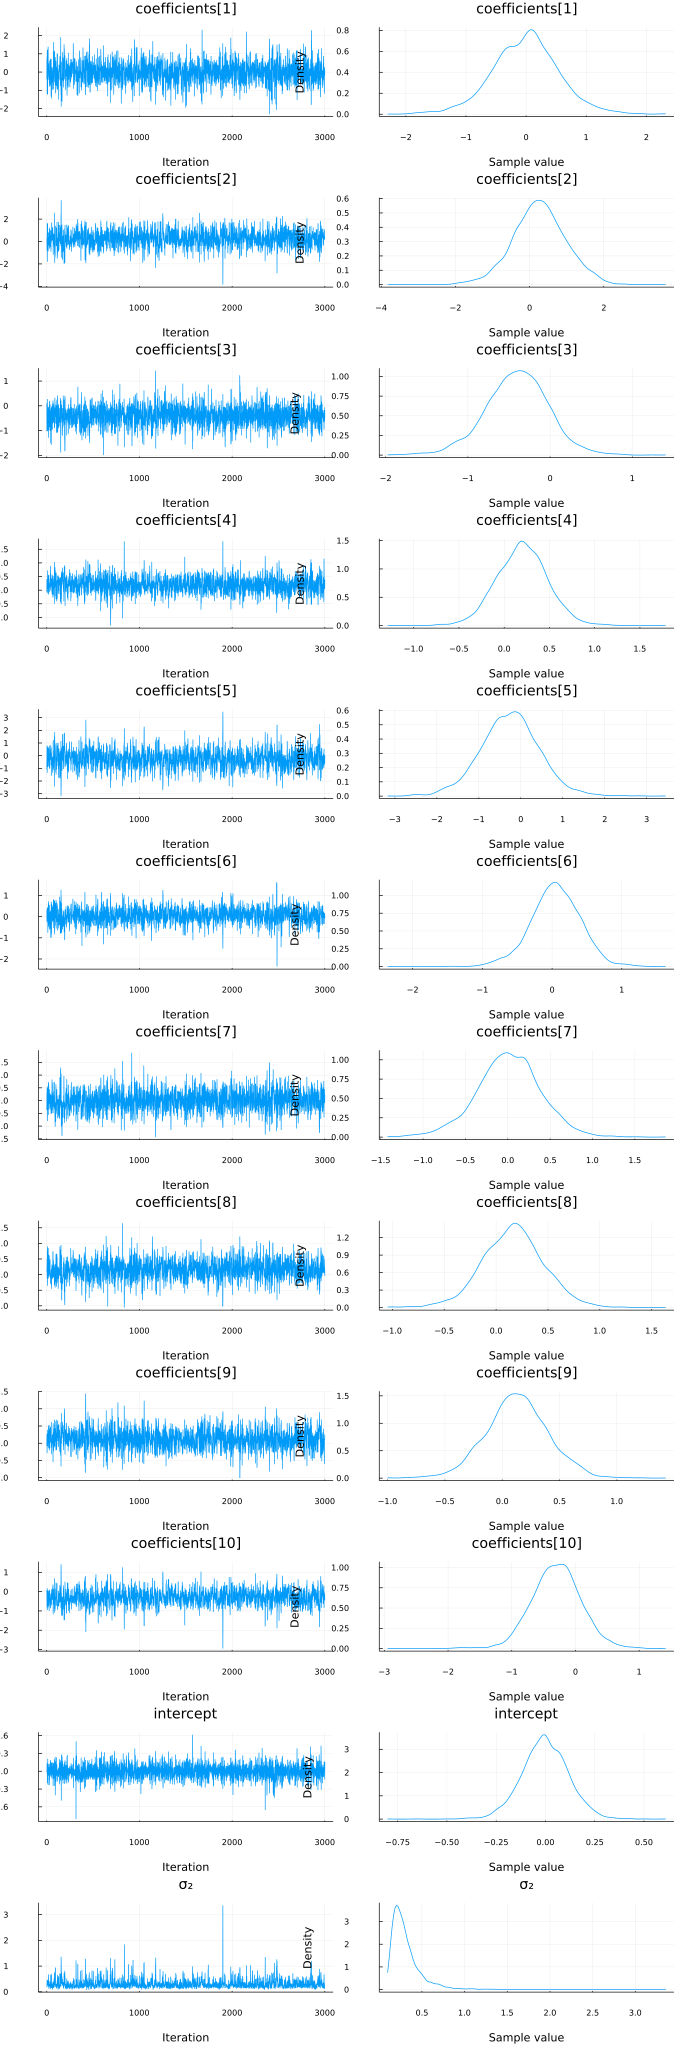

In [7]:
plot(chain)

It looks like each of our parameters has converged. We can check our numerical esimates using `describe(chain)`, as below.

In [8]:
dsc = describe(chain)
dsc[1]

Summary Statistics
        parameters      mean       std   naive_se      mcse         ess      r ⋯
            Symbol   Float64   Float64    Float64   Float64     Float64   Floa ⋯

   coefficients[1]   -0.0094    0.5606     0.0102    0.0105   1732.9598    1.0 ⋯
   coefficients[2]    0.2638    0.7188     0.0131    0.0175   1190.6418    0.9 ⋯
   coefficients[3]   -0.4036    0.3851     0.0070    0.0076   2080.8881    0.9 ⋯
   coefficients[4]    0.1979    0.2874     0.0052    0.0069   1392.2015    0.9 ⋯
   coefficients[5]   -0.2555    0.7082     0.0129    0.0198   1052.4962    0.9 ⋯
   coefficients[6]    0.0499    0.3638     0.0066    0.0092   1500.2910    1.0 ⋯
   coefficients[7]    0.0113    0.3835     0.0070    0.0097   1560.0330    1.0 ⋯
   coefficients[8]    0.1637    0.3018     0.0055    0.0079   1262.6236    1.0 ⋯
   coefficients[9]    0.1299    0.2746     0.0050    0.0069   1278.0314    1.0 ⋯
  coefficients[10]   -0.2987    0.3949     0.0072    0.0118    999.9680    1.0 ⋯
        

In [9]:
dsc[2]

Quantiles
        parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
            Symbol   Float64   Float64   Float64   Float64   Float64 

   coefficients[1]   -1.1639   -0.3611    0.0068    0.3375    1.1153
   coefficients[2]   -1.1789   -0.1935    0.2615    0.7251    1.6963
   coefficients[3]   -1.1950   -0.6408   -0.3901   -0.1536    0.3482
   coefficients[4]   -0.3553    0.0122    0.1983    0.3808    0.7473
   coefficients[5]   -1.7013   -0.7052   -0.2418    0.1861    1.1456
   coefficients[6]   -0.7202   -0.1718    0.0545    0.2853    0.7213
   coefficients[7]   -0.7728   -0.2234    0.0155    0.2486    0.7448
   coefficients[8]   -0.4546   -0.0293    0.1668    0.3555    0.7490
   coefficients[9]   -0.4072   -0.0411    0.1298    0.3031    0.6702
  coefficients[10]   -1.0423   -0.5468   -0.2941   -0.0529    0.4836
         intercept   -0.2388   -0.0771   -0.0035    0.0754    0.2302
                σ₂    0.1213    0.1946    0.2644    0.3661    0.7598


## Comparing to OLS

A satisfactory test of our model is to evaluate how well it predicts. Importantly, we want to compare our model to existing tools like OLS. The code below uses the [GLM.jl]() package to generate a traditional OLS multiple regression model on the same data as our probabalistic model.

In [10]:
# Import the GLM package.
using GLM

# Perform multiple regression OLS.
train_with_intercept = hcat(ones(size(train, 1)), train)
ols = lm(train_with_intercept, train_target)

# Compute predictions on the training data set
# and unstandardize them.
p = GLM.predict(ols)
train_prediction_ols = μtarget .+ σtarget .* p

# Compute predictions on the test data set
# and unstandardize them.
test_with_intercept = hcat(ones(size(test, 1)), test)
p = GLM.predict(ols, test_with_intercept)
test_prediction_ols = μtarget .+ σtarget .* p;

┌ Info: Precompiling GLM [38e38edf-8417-5370-95a0-9cbb8c7f171a]
└ @ Base loading.jl:1278


The function below accepts a chain and an input matrix and calculates predictions. We use the samples of the model parameters in the chain starting with sample 200, which is where the warm-up period for the NUTS sampler ended.

In [11]:
# Make a prediction given an input vector.
function prediction(chain, x)
    p = get_params(chain[200:end, :, :])
    targets = p.intercept' .+ x * reduce(hcat, p.coefficients)'
    return vec(mean(targets; dims = 2))
end

prediction (generic function with 1 method)

When we make predictions, we unstandardize them so they are more understandable.

In [12]:
# Calculate the predictions for the training and testing sets
# and unstandardize them.
p = prediction(chain, train)
train_prediction_bayes = μtarget .+ σtarget .* p
p = prediction(chain, test)
test_prediction_bayes = μtarget .+ σtarget .* p

# Show the predictions on the test data set.
DataFrame(
    MPG = testset[!, target],
    Bayes = test_prediction_bayes,
    OLS = test_prediction_ols
)

,MPG,Bayes,OLS
,Float64,Float64,Float64
1,19.2,18.2182,18.1265
2,15.0,6.16059,6.37891
3,16.4,13.9918,13.883
4,14.3,11.6075,11.7337
5,21.4,25.2373,25.1916
6,18.1,20.688,20.672
7,19.7,15.6838,15.8408
8,15.2,18.3806,18.3391
9,26.0,28.4643,28.4865


Now let's evaluate the loss for each method, and each prediction set. We will use the mean squared error to evaluate loss, given by 
$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^n {(y_i - \hat{y_i})^2}
$$
where $y_i$ is the actual value (true MPG) and $\hat{y_i}$ is the predicted value using either OLS or Bayesian linear regression. A lower SSE indicates a closer fit to the data.

In [13]:
println(
    "Training set:",
    "\n\tBayes loss: ",
    msd(train_prediction_bayes, trainset[!, target]),
    "\n\tOLS loss: ",
    msd(train_prediction_ols, trainset[!, target])
)

println(
    "Test set:",
    "\n\tBayes loss: ",
    msd(test_prediction_bayes, testset[!, target]),
    "\n\tOLS loss: ",
    msd(test_prediction_ols, testset[!, target])
)

Training set:
	Bayes loss: 4.650826645369283
	OLS loss: 4.6481420856905205
Test set:
	Bayes loss: 15.333978161680795
	OLS loss: 14.796847779051523


As we can see above, OLS and our Bayesian model fit our training and test data set about the same.